In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [64]:
# Reading data from directory

BASE_PATH = '../input/hot-dog-not-hot-dog/train/'
IMAGE_SIZE = (500, 500)

training_ds = tf.keras.utils.image_dataset_from_directory(
  BASE_PATH,
  validation_split=0.3,
  subset="training",
  seed=99,
  image_size=IMAGE_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  BASE_PATH,
  validation_split=0.3,
  subset="validation",
  seed=99,
  image_size=IMAGE_SIZE
)



Found 498 files belonging to 2 classes.
Using 349 files for training.
Found 498 files belonging to 2 classes.
Using 149 files for validation.


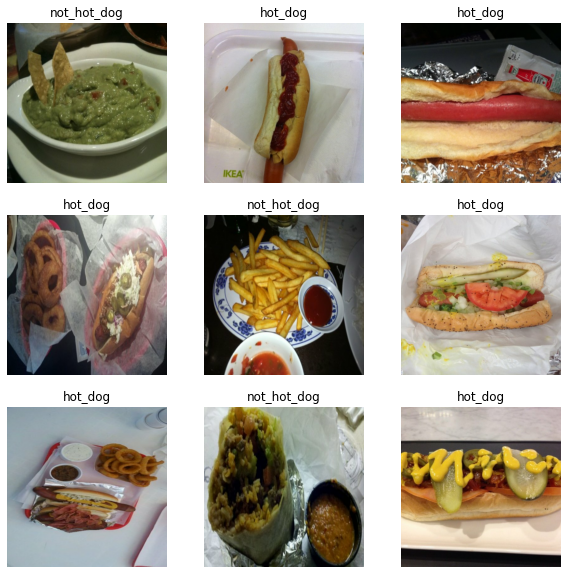

In [78]:
# Seeing some of the images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[labels[i]])
        plt.axis("off")

In [42]:
# Normalizing Data

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = training_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [43]:
# Configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
# Model creation
NUM_CLASSES = 2
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
])

In [54]:
# Compiling Model
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [66]:
# Training data
history = model.fit(
  training_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
11/11 [==============================] - 5s 374ms/step - loss: 2.0597e-07 - accuracy: 1.0000 - val_loss: 3.1662 - val_accuracy: 0.7383
Epoch 2/100
11/11 [==============================] - 5s 348ms/step - loss: 2.0426e-07 - accuracy: 1.0000 - val_loss: 3.1784 - val_accuracy: 0.7315
Epoch 3/100
11/11 [==============================] - 5s 363ms/step - loss: 2.0324e-07 - accuracy: 1.0000 - val_loss: 3.1672 - val_accuracy: 0.7383
Epoch 4/100
11/11 [==============================] - 5s 356ms/step - loss: 1.9299e-07 - accuracy: 1.0000 - val_loss: 3.1878 - val_accuracy: 0.7315
Epoch 5/100
11/11 [==============================] - 5s 355ms/step - loss: 1.9094e-07 - accuracy: 1.0000 - val_loss: 3.1712 - val_accuracy: 0.7383
Epoch 6/100
11/11 [==============================] - 5s 367ms/step - loss: 1.8889e-07 - accuracy: 1.0000 - val_loss: 3.1777 - val_accuracy: 0.7383
Epoch 7/100
11/11 [==============================] - 5s 364ms/step - loss: 1.8787e-07 - accuracy: 1.0000 - val_loss: 3

In [67]:
model.save_weights('/kaggle/working/weights.h5')
model.save('/kaggle/working/model.h5')

In [75]:
TEST_PATH = '../input/hot-dog-not-hot-dog/test/'
testing_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  subset=None,
  validation_split=None,
  seed=99,
  image_size=IMAGE_SIZE
)

Found 500 files belonging to 2 classes.


In [77]:
model.evaluate(testing_ds)

16/16 [==============================] - 4s 148ms/step - loss: 4.6402 - accuracy: 0.5760


[4.640192985534668, 0.5759999752044678]